In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm
# import pickle

import hexbin_functions as hexfunc

In [3]:
def create_dataframe(probability_sets, entropy_sets, hexints):
    """
    Creates xarray Dataframe containing the probability and entropy data.

    Parameters
    ----------
    probability_sets : dict
        Dictionary containing probability data arrays for each delta_t.
    entropy_sets : dict
        Dictionary containing entropy data arrays for each delta_t.
    hexints : list
        List of hexagonal bin indices.
    obs_length : int
        The length of the observation period.
    filename : str
        The filename to save the NetCDF file.
    
    Returns
    -------
    ds : xarray.Dataset
        The dataset containing the probability and entropy data.
    """

    ds = xr.Dataset(
        {
            'probability': xr.DataArray(
                np.array([probability_sets[i] for i in range(0, 15)]),
                dims=['delta_t', 'hexint', 'time'],
                coords={
                    'delta_t': range(0, 15),
                    'hexint': hexints,
                    'time': range(probability_sets[0].shape[1])
                },
                attrs={
                    'description': 'Probability of occurrence for each time step, hexagonal bin, and observation time',
                    'units': 'probability'
                }
            ),
            'entropy': xr.DataArray(
                np.array([entropy_sets[i] for i in range(0, 15)]),
                dims=['delta_t', 'time'],
                coords={
                    'delta_t': range(0, 15),
                    'time': range(probability_sets[0].shape[1])
                },
                attrs={
                    'description': 'Entropy values for each time step and observation time',
                    'units': 'nats'
                }
            )
        }
    )
    
    return ds

In [15]:
def entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log(Pdf_safe))

def information(Pdf):
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return - Pdf_safe * np.log2(Pdf_safe)

def Shannon_entropy(Pdf):
    # Pdf = Pdf / np.nansum(Pdf)  # Normalize Pdf to sum to 1, ignoring NaNs
    # Replace zeros with a very small number to avoid log(0)
    Pdf_safe = np.where(Pdf > 0, Pdf, np.finfo(float).eps)
    return -np.nansum(Pdf_safe * np.log2(Pdf_safe))

In [1]:
location = 'Cape_Hatteras'
member = 50
std = 0.01

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}/P_std{std*100:03.0f}_m{member:03d}.zarr"
P_m = xr.open_zarr(file_path)

NameError: name 'xr' is not defined

In [5]:
P_m['probability'].values.shape

(4, 4644, 1400)

In [6]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)

# Make probability distributions for all members (available)

In [11]:
location = 'Cape_Hatteras'
member = 50
std = 0.01

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
P_m = xr.open_zarr(file_path)

In [20]:
def create_dataframe(probability_sets, entropy_sets, hexints, delta_t_range, time_range):
    """
    Creates xarray Dataframe containing the probability and entropy data.

    Parameters
    ----------
    probability_sets : dict
        Dictionary containing probability data arrays for each delta_t.
    entropy_sets : dict
        Dictionary containing entropy data arrays for each delta_t.
    hexints : list
        List of hexagonal bin indices.
    obs_length : int
        The length of the observation period.
    filename : str
        The filename to save the NetCDF file.
    
    Returns
    -------
    ds : xarray.Dataset
        The dataset containing the probability and entropy data.
    """

    ds = xr.Dataset(
        {
            'probability': xr.DataArray(
                np.array([probability_sets[i] for i in range(len(delta_t_range))]),
                dims=['delta_t', 'hexint', 'time'],
                coords={
                    'delta_t': delta_t_range,
                    'hexint': hexints,
                    'time': time_range
                },
                attrs={
                    'description': 'Probability of occurrence for each time step, hexagonal bin, and observation time',
                    'units': 'probability'
                }
            ),
            'entropy': xr.DataArray(
                np.array([entropy_sets[i] for i in range(len(delta_t_range))]),
                dims=['delta_t', 'time'],
                coords={
                    'delta_t': delta_t_range,
                    'time': time_range
                },
                attrs={
                    'description': 'Entropy values for each time step and observation time',
                    'units': 'nats'
                }
            )
        }
    )
    
    return ds

In [21]:
P_AX.shape

(4, 4644, 1400)

In [22]:
stds = np.linspace(1, 20, 20)/100

location = 'Cape_Hatteras'
members =  [1, 2, 44, 46, 47, 48, 49, 50]
stds = np.linspace(1, 20, 20)/100
N_gropus = len(P_m.delta_t)
delta_t_array = P_m.delta_t.values
N_bins = len(P_m.hexint)
N_times = len(P_m.time)
time_array = P_m.time.values
P_AX = np.zeros((N_gropus, N_bins, N_times))

    
for std in tqdm(stds):
    P_AX = np.zeros((N_gropus, N_bins, N_times))
    for member in members:

        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_m{member:03d}.zarr"
        P_m = xr.open_zarr(file_path)
        
        P_AX += P_m['probability'].values
        
    P_AX_norm = np.zeros_like(P_AX)

    H_AX = np.zeros((N_gropus, N_times))

    for j, gap in enumerate(delta_t_array):
        for t in range(N_times):
            P_AX_norm[j, :, t] = P_AX[j, :, t]/P_AX[j, :, t].sum()
            H_AX[j, t] = entropy(P_AX_norm[j, :, t])
            
    P_AX = P_AX_norm
    
    DF_std = create_dataframe(P_AX, H_AX, P_m.hexint.values, delta_t_array, time_array)
    DF_std.to_zarr(f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}_coarse/P_std{std*100:03.0f}_all.zarr")

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_55554/2309578786.py:29: RuntimeWarning: invalid value encountered in divide
  P_AX_norm[j, :, t] = P_AX[j, :, t]/P_AX[j, :, t].sum()
100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


In [25]:
DF_std

<xarray.Dataset> Size: 208MB
Dimensions:      (delta_t: 4, hexint: 4644, time: 1400)
Coordinates:
  * delta_t      (delta_t) int64 32B 24 36 48 60
  * hexint       (hexint) int64 37kB 590889505955774463 ... 590726709515386879
  * time         (time) int64 11kB 0 1 2 3 4 5 ... 1394 1395 1396 1397 1398 1399
Data variables:
    probability  (delta_t, hexint, time) float64 208MB 0.0 0.0 0.0 ... nan nan
    entropy      (delta_t, time) float64 45kB 1.15 1.87 ... 3.717e-11 3.717e-11

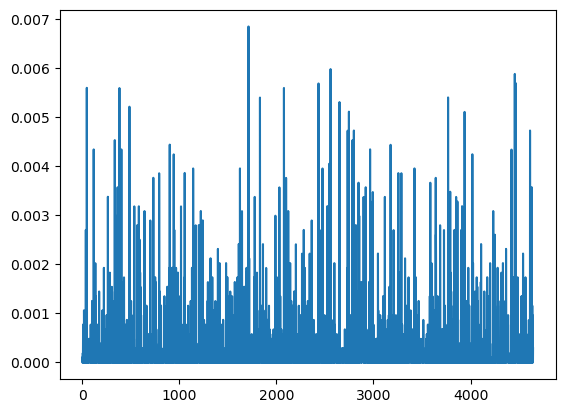

In [27]:
plt.plot(DF_std['probability'].values[0, :, 1000])

# Load the files

In [28]:
hex_grid = hexfunc.int_to_hex(P_m.hexint.values)
hexbin_grid = hexfunc.hexGrid(hex_grid, h3_res=3)


In [29]:
std = 0.01
P_AX_001 = xr.open_zarr(f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/analysis/prob_distribution/{location}/P_std{std*100:03.0f}_all.zarr")

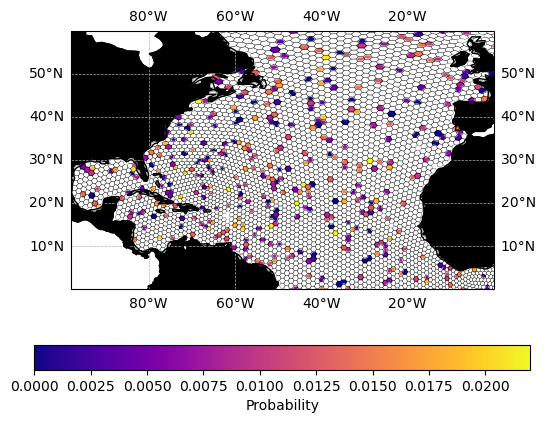

In [30]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

t = 365
t_gap = 1

im = hexbin_grid.pcolorhex(P_AX_001['probability'][t_gap, :, t].values, ax=ax, cmap='plasma', draw_edges=True)
# add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label='Probability')

IndexError: index 4 is out of bounds for axis 0 with size 4

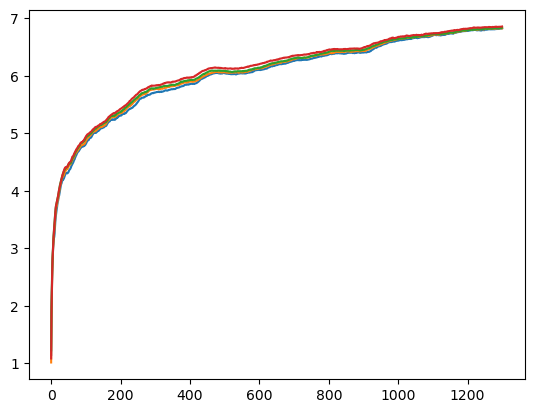

In [31]:
for delta_t in range(0, 15):
    plt.plot(H_AX[delta_t, :1300], label=f'{delta_t} hrs gap')
    
plt.legend()
plt.ylabel('Entropy (nats)')
plt.ylabel('Time (days)')

Daan, On behalf of the parcels team I wanted to wish you farewell. You've been a very important member of our team. Always very kind and helpful. We will miss you around here and we wish you the best of luck for the future. 

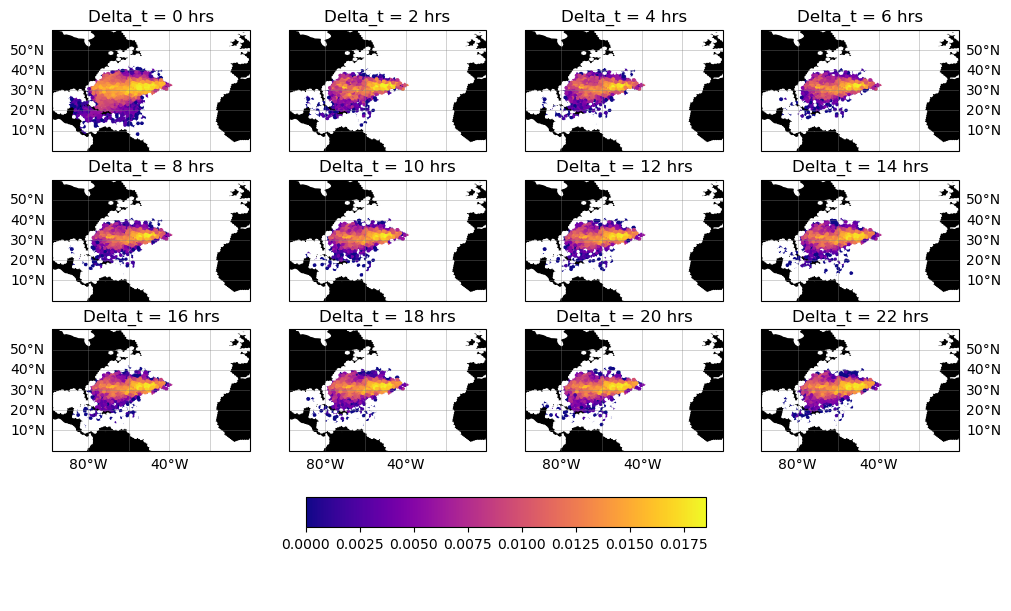

In [23]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(10, 6),
                       subplot_kw={'projection': cartopy.crs.PlateCarree()},
                       sharey=True, constrained_layout=True)

axs = axs.reshape(16)

for i in range(12):
    
    axs[i].set_extent([-98, 0, 0, 60], crs=cartopy.crs.PlateCarree())
    axs[i].add_feature(cartopy.feature.LAND, zorder=0, color='black')
    
    axs[i].set_title(f'Delta_t = {i*2} hrs')
    gl = axs[i].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.5)

    im = hexbin_grid.pcolorhex(P_AX_001['probability'][i, :, t].values, ax=axs[i], cmap='plasma', draw_edges=False)
    if i in [1, 2, 3, 5, 6, 7, 9, 10, 11]:
        gl.left_labels = False

    if i in [0, 1, 2, 3, 4, 5, 6, 7]:
        gl.bottom_labels = False

    gl.top_labels = False
    gl.right_labels = False

    if i in [3, 7, 11]:
        gl.right_labels = True

for i in range(12, 16):
    axs[i].axis('off')

# ax[12].legend(handles=[h], loc='upper center', shadow=True)
bar_ax = fig.add_axes([0.3, 0.13, 0.4, 0.05])
cbar = fig.colorbar(im, cax=bar_ax, orientation='horizontal')

# plt.savefig(output_path + 'posterior.pdf', format='pdf')
# plt.savefig(output_path + 'posterior.jpg', format='jpg', dpi=300)